#  Importing Packages

In [1]:
#Import Packages
import pandas as pd
import numpy as np
from pprint import pprint
import re
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Importing Dataset

In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


content  target  \
0  From: lerxst@wam.umd.edu (where's my thing)\nS...       7   
1  From: guykuo@carson.u.washington.edu (Guy Kuo)...       4   
2  From: twillis@ec.ecn.purdue.edu (Thomas E Will...       4   
3  From: jgreen@amber (Joe Green)\nSubject: Re: W...       1   
4  From: jcm@head-cfa.harvard.edu (Jonathan McDow...      14   

            target_names  
0              rec.autos  
1  comp.sys.mac.hardware  
2  comp.sys.mac.hardware  
3          comp.graphics  
4              sci.space

# Preprocessing for Dataset

In [4]:
###Remove emails and newline characters
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<ipython-input-4-3b9674f19907>:6: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-4-3b9674f19907>:9: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [5]:
###Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [6]:
###Creating Bigram and Trigram Models
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [7]:
###Remove Stopwords, Make Bigrams and Lemmatize
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


D:\anaconda3\envs\lda\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [10]:
### Create the Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


In [11]:
id2word[60]

'knowledge'

In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [13]:
###Building the Topic Model
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
### View the topics in LDA model
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.175*"file" + 0.073*"entry" + 0.057*"error" + 0.053*"display" + '
  '0.040*"program" + 0.030*"sun" + 0.025*"version" + 0.024*"cool" + '
  '0.020*"output" + 0.020*"crash"'),
 (1,
  '0.032*"would" + 0.026*"say" + 0.022*"think" + 0.022*"people" + 0.020*"go" + '
  '0.018*"know" + 0.016*"make" + 0.016*"see" + 0.014*"come" + 0.013*"thing"'),
 (2,
  '0.091*"evidence" + 0.048*"book" + 0.041*"faith" + 0.037*"reason" + '
  '0.033*"exist" + 0.032*"claim" + 0.031*"religion" + 0.029*"believe" + '
  '0.027*"christian" + 0.023*"church"'),
 (3,
  '0.541*"ax" + 0.054*"car" + 0.028*"player" + 0.014*"engine" + 0.009*"dealer" '
  '+ 0.009*"mile" + 0.009*"expensive" + 0.009*"here" + 0.008*"extra" + '
  '0.008*"specify"'),
 (4,
  '0.087*"belief" + 0.084*"internet" + 0.079*"atheist" + 0.061*"distribution" '
  '+ 0.053*"wing" + 0.041*"atheism" + 0.038*"printer" + 0.034*"interface" + '
  '0.026*"multiple" + 0.020*"thinking"'),
 (5,
  '0.088*"normal" + 0.072*"port" + 0.071*"mouse" + 0.053*"hole" + 0.03

In [17]:
### Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -12.486508480350782

Coherence Score:  0.49288861569721343


In [18]:
### Hyperparameter Tuning
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [23]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model resultsp
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████| 540/540 [11:59:04<00:00, 79.90s/it]


In [22]:
###Visualize the topics-keywords
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.335630 -0.217728       1        1  28.084646
18    -0.302088 -0.145015       2        1  18.153516
9     -0.271880 -0.004601       3        1  15.587229
19    -0.213916  0.101537       4        1   8.163035
3      0.014730  0.121697       5        1   5.748549
10    -0.144862  0.268469       6        1   5.679891
6     -0.129685  0.185627       7        1   5.134635
2     -0.061841 -0.076528       8        1   2.129780
14    -0.018005 -0.093243       9        1   1.930829
16     0.000229  0.059321      10        1   1.922011
11     0.069657  0.074449      11        1   1.423830
0      0.119147  0.020981      12        1   1.152388
12     0.109099 -0.008045      13        1   1.039395
8      0.085485 -0.055231      14        1   0.971989
7      0.131145 -0.010036      15        1   0.884548
4      0.160738 -0.037302      16        1   0.697291
13     0.172285 -0.042789      17        1   0.449755
15     0.198402 -0.044227      18        1   0.375348
5      0.200337 -0.048558      19        1   0.334448
17     0.216654 -0.048777      20        1   0.136887, topic_info=              Term          Freq         Total Category  logprob  loglift
3718            ax  36366.000000  36366.000000  Default  30.0000  30.0000
18            line  15682.000000  15682.000000  Default  29.0000  29.0000
197          write  13139.000000  13139.000000  Default  28.0000  28.0000
39            year   4567.000000   4567.000000  Default  27.0000  27.0000
140         people   7716.000000   7716.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
6226  redistribute      0.026008      1.250148  Topic20 -11.0266   2.7211
6951     judgement      0.026008      1.250166  Topic20 -11.0266   2.7211
9115      tomorrow      0.026008      1.250172  Topic20 -11.0266   2.7211
5664  announcement      0.026008      1.250199  Topic20 -11.0266   2.7211
4072          baby      0.026008      1.250176  Topic20 -11.0266   2.7211

[866 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1227      1  0.999083        accept
345      15  0.914019    acceptance
326      17  0.943325  accidentally
0         7  0.998116      addition
175       2  0.399798       address
...     ...       ...           ...
39        1  0.028024          year
39        3  0.824311          year
39       14  0.147347          year
722      13  0.992129     yesterday
570       1  0.998440         young

[1113 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 19, 10, 20, 4, 11, 7, 3, 15, 17, 12, 1, 13, 9, 8, 5, 14, 16, 6, 18])

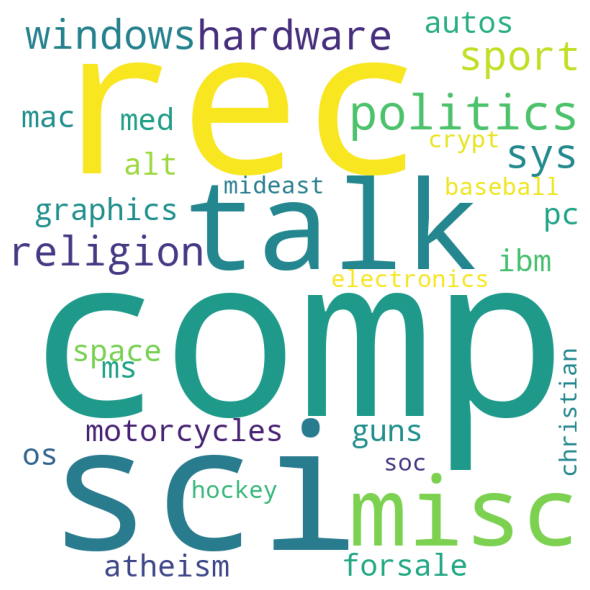

In [24]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.target_names.unique(): 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
     comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()